In [1]:
exp_name = "VA13R3"

# Execute all

In [2]:
%matplotlib inline

C:\Users\tifa-\AppData\Roaming\Python\Python38\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\tifa-\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.gk7gx5keq4f6uyo3p26ulgbqyhgqo7j4.gfortran-win_amd64.dll
C:\Users\tifa-\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spectral as sp
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import os

In [4]:
def plot_spectra(img, wave_lengths=(100,200,300), grid_step=20):
    sp.imshow(img, wave_lengths,aspect="auto")
    ax = plt.gca()
    ax.set_xticks(np.arange(0, img.shape[1], int(img.shape[1]/grid_step)))
    ax.set_yticks(np.arange(0, img.shape[0], int(img.shape[0]/grid_step)))
    plt.xticks(rotation=75)
    ax.grid(color='k', linestyle=':', linewidth=1)
    plt.xlabel("y",fontsize=15)
    plt.ylabel("x",fontsize=15)

In [5]:
def save_spectrum_to_file(spectrum, id_, file):
    if os.path.isfile(file):
        spectra =  pd.read_csv(file, header=0, index_col=0)
    else:
        spectra = pd.DataFrame(columns=spectrum.index)
    spectra.loc[id_] = spectrum
    spectra.to_csv(file,header=True)

###  Get wave lengths

In [6]:
wave_lengths = pd.read_csv("wave_lengths.csv",index_col=0,sep=';',header=None)[1]

## Load the dataset
### Choose your path

In [7]:
current_dir = "D:/Donnees_camera/Seul/"

In [8]:
image_path = current_dir+exp_name+'/capture/'+exp_name+'.hdr'

In [9]:
img = sp.open_image(image_path)

C:\ProgramData\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


### Plot the image

In [10]:
img.shape

(958, 1024, 448)

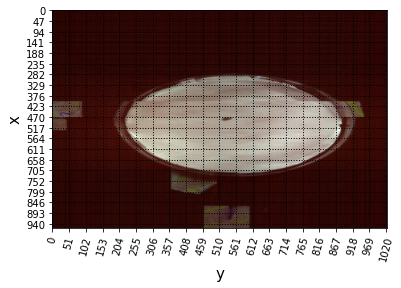

In [11]:
plot_spectra(img,  wave_lengths=(29,113,227), grid_step=20)

In [12]:
img.shape

(958, 1024, 448)

### Select the appropriate zoom

In [19]:
x_zoom = (455,505)
y_zoom = (510,560)

In [20]:
img_zoom = img[x_zoom[0]:x_zoom[1],y_zoom[0]:y_zoom[1], :]

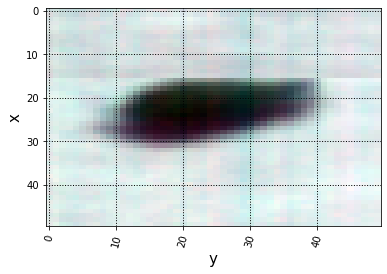

In [21]:
plot_spectra(img_zoom,  wave_lengths=(42,131,227), grid_step=5)

# PCA
### Reduce the dataset dimensionality

In [22]:
nb_PC = 30
pca = PCA(n_components=nb_PC)
data_points = img_zoom.reshape(-1,img_zoom.shape[2])
pca = pca.fit(data_points)

### Plot the importance of each new principal component

Text(0, 0.5, '$log(ExplainedVAR)$')

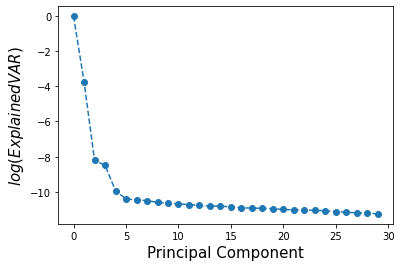

In [23]:
plt.plot(np.log(pca.explained_variance_ratio_),"o--")
plt.xlabel("Principal Component",fontsize=15)
plt.ylabel("$log(ExplainedVAR)$",fontsize=15)

### Choose the number of Principal Components to keep

In [24]:
nb_PC_to_keep = 5

### Plot the image along each Principal Component

In [25]:
data_points_pca = pca.transform(data_points)
data_points_pca = data_points_pca[:,:nb_PC_to_keep].reshape((img_zoom.shape[0],img_zoom.shape[1],nb_PC_to_keep))

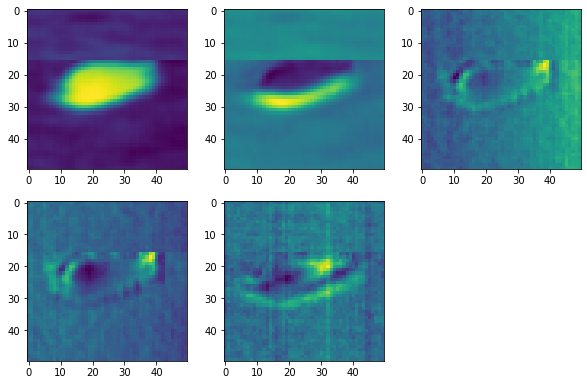

In [26]:
fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 3
for pc in range(nb_PC_to_keep):
    fig.add_subplot(rows, columns, pc+1)
    plt.imshow(data_points_pca[:,:,pc])


# Kmeans
### Detect clusters of similar pixels

In [37]:
nb_clusters = 3

In [38]:
max_dim = 1
min_dim = 0
data_points_for_clustering = data_points_pca[:,:,min_dim:max_dim].reshape(-1,max_dim-min_dim)
z_scored = (data_points_for_clustering - data_points_for_clustering.mean(axis=0)) / data_points_for_clustering.std(axis=0)

In [39]:
kmeans = KMeans(n_clusters=nb_clusters)
kmeans.fit(z_scored)
cluster_membership = kmeans.predict(z_scored)

In [40]:
m = cluster_membership.reshape((img_zoom.shape[0],img_zoom.shape[1],1))

### Plot cluster memberships

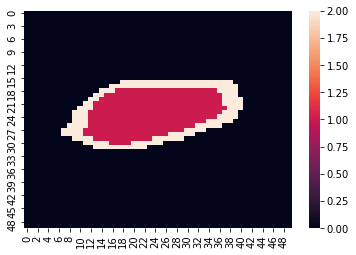

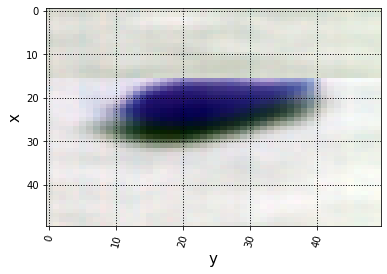

In [41]:
sns.heatmap(m[:,:,0])
plot_spectra(img_zoom,  wave_lengths=(100,200,300), grid_step=5)

### Choose the animal cluster id

In [42]:
clust_id = 1

## Compute AVG spectrum and SD

In [43]:
c_img = img_zoom[m[:,:,0]==clust_id]
avg_spectrum = pd.Series(c_img.mean(axis=0), index = wave_lengths)
std_spectrum = pd.Series(c_img.std(axis=0), index = wave_lengths)


### Plot the spectrum

Text(0.5, 0, 'Wave Length')

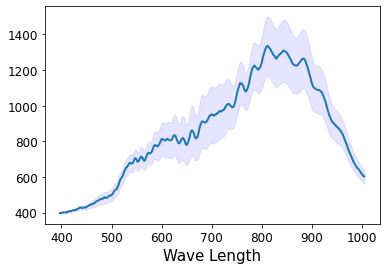

In [44]:
plt.plot(avg_spectrum, linewidth=2)
plt.fill_between(avg_spectrum.index, (avg_spectrum-std_spectrum), (avg_spectrum+std_spectrum), color='b', alpha=.1)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel("Wave Length",fontsize=15)

### Read references

In [45]:
dark_ref_path = current_dir+exp_name+'/capture/DARKREF_'+exp_name+'.hdr'
white_ref_path = current_dir+exp_name+'/capture/WHITEREF_'+exp_name+'.hdr'

In [46]:
dark_ref = sp.open_image(dark_ref_path)
dark_spectrum = dark_ref.asarray().reshape(-1,dark_ref.shape[2]).mean(axis=0)

white_ref = sp.open_image(white_ref_path)
white_spectrum = white_ref.asarray().reshape(-1,white_ref.shape[2]).mean(axis=0)

C:\ProgramData\Anaconda3\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


### Normalize spectrum

In [47]:
norm_c_img = (c_img - dark_spectrum)/(white_spectrum - dark_spectrum)
norm_avg_spectrum = pd.Series(norm_c_img.mean(axis=0), index = wave_lengths)
norm_std_spectrum = pd.Series(norm_c_img.std(axis=0), index = wave_lengths)

### Plot normalized spectrum

Text(0.5, 0, 'Wave Length')

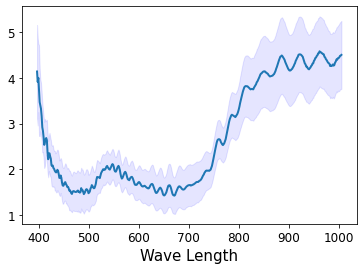

In [48]:
plt.plot(norm_avg_spectrum, linewidth=2)
plt.fill_between(norm_avg_spectrum.index, (norm_avg_spectrum-norm_std_spectrum), (norm_avg_spectrum+norm_std_spectrum), color='b', alpha=.1)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel("Wave Length",fontsize=15)

# Save spectrum aphid cluster

In [1737]:
id_ = image_path.split("/")[-1].split(".")[0]

In [1738]:
data_set_name_avg_raw = "spectrum_avg_raw.csv"
data_set_name_std_raw = "spectrum_std_raw.csv"
data_set_name_avg_norm = "spectrum_avg_norm.csv"
data_set_name_std_norm = "spectrum_std_norm.csv"

In [1739]:
save_spectrum_to_file(avg_spectrum, id_, data_set_name_avg_raw)
save_spectrum_to_file(std_spectrum, id_, data_set_name_std_raw)
save_spectrum_to_file(norm_avg_spectrum, id_, data_set_name_avg_norm)
save_spectrum_to_file(norm_std_spectrum, id_, data_set_name_std_norm)